[View in Colaboratory](https://colab.research.google.com/github/SalmaAhmed95/Twitter-Sentiment-Classification-Using-Distant-Supervision/blob/master/ArabicTwitterSentimentAnalysis.ipynb)

In [1]:
# This cell connects to google drive, authenticates connection, and iterates over file list displaying each file's title and ID.
# it also imports and installs all the necessary libraries
!pip install -U -q PyDrive
!pip install -U -q wordcloud
!pip install -U -q bokeh
!pip install textblob

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from bs4 import BeautifulSoup

from wordcloud import WordCloud
from scipy.stats import hmean
from scipy.stats import norm
from pylab import *
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from textblob import TextBlob
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from time import time

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_list = drive.ListFile(
    {'q': "'1UHoxe2J0_QVgWD1P4BdF94CVALiHn3S5' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


title: ArabicTwitterSentimentAnalysis.ipynb, id: 1vFKIwtlbsyjjA2Q8kPw3SzQ8sjYsXxbZ
title: clean_Arabic_Tweets_1600000Tweet.csv, id: 1fRMY2iwapHLnXE3jlRjveeg2Ihz-aD6h
title: TwitterSentimentAnalysis.ipynb, id: 1A9doDERyDk5qz9Hy0LykCXeQdqKvmlMn
title: clean_Arabic_Tweets_1600000Tweet.csv, id: 1aaHKTwFJDnlw-TJuK4whN_fLn0isLvfv
title: ArabicTweetsNonClean.csv, id: 1TNaUswMaVMhkWTEdNpeRBVwbizi6uKyZ
title: data3.zip, id: 1Ppsec65-wQ7eZpKWJLPmj_HPyj2EEhNF
title: positive.zip, id: 1VAMxTC7UAyk-fBRXCmQZ5T75w62zdhL4
title: Twitter Sentiment Analysis report, id: 1LKyzCRnL3Y6Bila7iQgcBuMO8V279NHKfSgCBa_Xa0E
title: clean_Tweets_1600000Tweet.csv, id: 1bFJu26UFNgkYU0u0hANXAfvfz3-L-2Ry
title: clean_Tweets_1.6millionTweet.csv, id: 1auKc_BBHVk-FQJkOIyLrlCS-ivRW3fIx
title: training.1600000.processed.noemoticon.csv, id: 1XdARv07vjTvdAPHgwFrMobo-ivCaO8U-
title: Arabic Dataset Collection, id: 1sBc-KW9HQ6pf5C9u-jiSYTt6CvkQP9Kl00GQOMmlvc0
title: Research Implementation plan, id: 1DSyAZ2xmklZEys_xtWf1x_YUUj6WQ

In [0]:
training_data = drive.CreateFile({'id': '1TNaUswMaVMhkWTEdNpeRBVwbizi6uKyZ'})
training_data.GetContentFile('ArabicTweetsNonClean.csv')  

# upload file into pandas dataframe and drop unnecessary columns and neutral rows

df_train = pd.read_csv('ArabicTweetsNonClean.csv',header=None, names = ["text","target"], usecols = [1,2],encoding='utf-8')
clean_tweets = []   
# # drop rows with retweet text 
# df_train.drop(df_train[df_train.text.str.contains(' RT ')].index, inplace=True)
df_train.drop(df_train.index[0], inplace=True)

df_train

In [69]:
# df_clean.loc[df_clean['target'] == 4, 'target'] = 1
df_train.loc[df_train['target'] == u'0', 'target'] = 0
df_train.loc[df_train['target'] == 4, 'target'] = 1
df_train

,text,target
1,معنديش جذور للأسف في الأرياف أو الصعيد نسافر ل...,0
2,نغزات القلب :(,0
3,*تايد اوكسي :( https:// twitter.com/elzhra_zob...,0
4,عندما نكذب..نكره أنفسنا وعندما نكون صادقين..ي...,0
5,اوه حبيبي :( https:// twitter.com/ALTupdate/s...,0
6,تورو خداااا :((((,0
7,كالحرب انت دمرتني بغيابك :(,0
8,يا جماعة انا حلمت بالعسيلي و الحلم كان قمر و ا...,0
9,روحي :( pic.twitter.com/MajuLdHYAP,0
10,أنا منهك من التخمين والفوضى، ودي لو أغادرني :(.,0


In [4]:
df_train.loc[(df_train['target'] != 1) & df_train['target'] != 0]

,text,target


In [0]:
#data preprocessing
# sys.setdefaultencoding('utf-8')
chunks_range = [1,400000,800000,1200000,1673285] 
for i in range(chunks_range[3],chunks_range[4]):   #repeat for all range
  clean_tweets.append(clean(df_train['text'][i]))
  


In [0]:
#Strips emojis
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :'),:D, : D, =)
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))|:\s?D | =\)', '', tweet)
    # Sad -- :-(, : (, :(, ):, )-: , :p
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)|:p', '', tweet)
    return tweet
  

In [0]:
#clean data
url = re.compile(r"(?:(http[s]?://)|((//)?(\w+\.)?\w+\.\w+/\S+))")
user_mention = re.compile(r"(?:(?<!\w)@\w+\b)")
number = re.compile(r"(?:\b\d+\b)")
length_repeated_char = '\\1\\1'

def clean(raw):
  #convert HTML encoding to text
  new_row = BeautifulSoup(raw, 'html.parser').get_text()
  
  #Change all text to lower case
  new_row = new_row.lower()
  
  #Replaces any url with class URL
  new_row = re.sub(url, '', new_row)
  
  #replace any @username with class USERNAME
  new_row = re.sub(user_mention, '', new_row)
  
  #Strips repeated chars
  
  p_longation = re.compile(r'(.)\1+')
  subst = r"\1\1"
  new_row = re.sub(p_longation, subst, new_row)
    
  
  #Replaces #hashtag with hashtag
  new_row = re.sub(r'#(\S+)', r' \1 ', new_row)
  
  #Remove numbers
  new_row = re.sub(number, '', new_row)
  
  #decode text with 'utf-8-sig'
  try:
    temp_row = new_row.decode("utf-8-sig").replace(u"\ufffd", "?")     
  except:
    temp_row = new_row
  
  #Removes emojis
  new_row = handle_emojis(temp_row);
  return new_row

#print(clean("هووووم"))


In [0]:
#save to csv file
print(clean_tweets)
clean_df = pd.DataFrame(clean_tweets, columns=['text'])
clean_df['target'] = df_train.target



In [77]:
clean_df

,text,target
0,معنديش جذور للأسف في الأرياف أو الصعيد نسافر ل...,NaN
1,نغزات القلب,0
2,*تايد اوكسي atus/ …,0
3,عندما نكذب..نكره أنفسنا وعندما نكون صادقين..ي...,0
4,اوه حبيبي us/ …,0
5,تورو خداا (,0
6,كالحرب انت دمرتني بغيابك,0
7,يا جماعة انا حلمت بالعسيلي و الحلم كان قمر و ا...,0
8,روحي,0
9,أنا منهك من التخمين والفوضى، ودي لو أغادرني .,0


In [12]:
clean_df.to_csv('clean_Arabic_Tweets_1600000Tweet.csv',encoding='utf-8')

file = drive.CreateFile({'parents':[{u'id': '1UHoxe2J0_QVgWD1P4BdF94CVALiHn3S5'}]})
file.SetContentFile("clean_Arabic_Tweets_1600000Tweet.csv")
file.Upload()

NameError: ignored

In [0]:
# Reading clean data from drive and saving it locally in memory
import sys  
reload(sys)  
sys.setdefaultencoding('utf-8')
clean_data = drive.CreateFile({'id': '1fRMY2iwapHLnXE3jlRjveeg2Ihz-aD6h'})
clean_data.GetContentFile('clean_Arabic_Tweets_1600000Tweet.csv')  

df_clean = pd.read_csv('clean_Arabic_Tweets_1600000Tweet.csv',header=None, names = ["text","target"], usecols = [1,2], encoding='utf-8', error_bad_lines=False)
df_clean


In [4]:
df_clean.loc[df_clean['target'] == u'0', 'target'] = 0
df_clean

,text,target
0,text,target
1,معنديش جذور للأسف في الأرياف أو الصعيد نسافر ل...,NaN
2,نغزات القلب,0
3,*تايد اوكسي atus/ …,0
4,عندما نكذب..نكره أنفسنا وعندما نكون صادقين..ي...,0
5,اوه حبيبي us/ …,0
6,تورو خداا (,0
7,كالحرب انت دمرتني بغيابك,0
8,يا جماعة انا حلمت بالعسيلي و الحلم كان قمر و ا...,0
9,روحي,0


In [5]:
df_clean.loc[(df_clean['target'] != 1) & df_clean['target'] != 0]

,text,target
0,text,target


In [6]:
# Checking read cleaned file info if there are any null entries (found none) or white space
df_clean.info()
df_clean['text'] = df_clean['text'].str.strip()
df_clean.drop(df_clean[df_clean.text == ''].index, inplace=True)
df_clean.drop(df_clean[df_clean.target.isnull()].index,inplace=True)
df_clean

,text,target
0,text,target
2,نغزات القلب,0
3,*تايد اوكسي atus/ …,0
4,عندما نكذب..نكره أنفسنا وعندما نكون صادقين..ي...,0
5,اوه حبيبي us/ …,0
6,تورو خداا (,0
7,كالحرب انت دمرتني بغيابك,0
8,يا جماعة انا حلمت بالعسيلي و الحلم كان قمر و ا...,0
9,روحي,0
10,أنا منهك من التخمين والفوضى، ودي لو أغادرني .,0


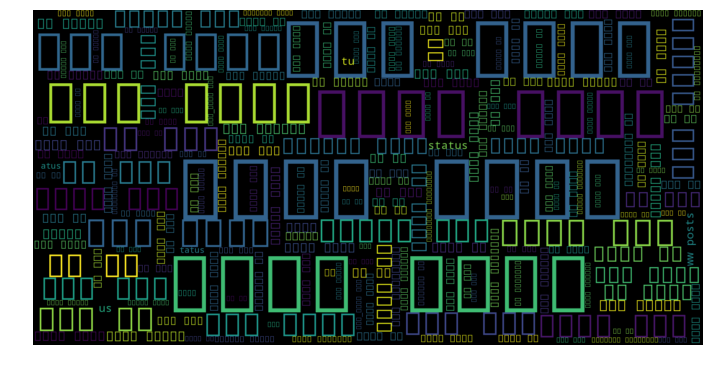

In [42]:
# Visualizing negative tweets in a word cloud format
from arabic_reshaper import arabic_reshaper
from bidi.algorithm import get_display
import sys
reload(sys)
sys.setdefaultencoding('utf8')

neg_tweets = df_clean[df_clean.target == 0]
neg_string = []
for t in neg_tweets.text:
    t = t.decode("utf-8")
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')


wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [0]:
# Visualizing negative tweets in a word cloud format
from arabic_reshaper import arabic_reshaper
from bidi.algorithm import get_display
import sys

reload(sys)
sys.setdefaultencoding('utf8')

t='انا احب اللغة العربية و حروفها I love English words'
t = t.decode("utf-8")
t = arabic_reshaper.reshape(t)
t = get_display(t)

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(t)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


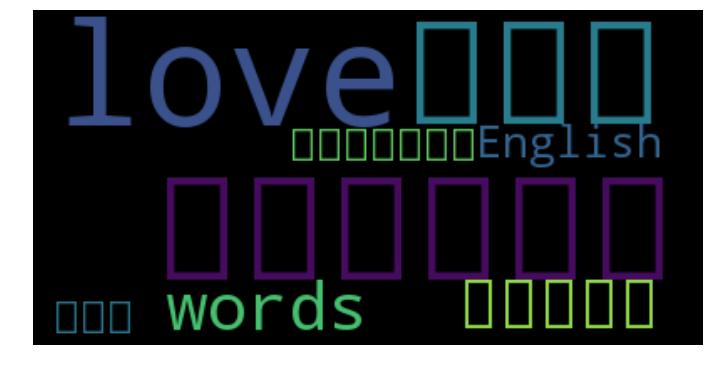

In [35]:
#word cloud issues with arabic trial
!pip install python-bidi
!pip install --upgrade arabic-reshaper
!pip install -U -q wordcloud
!wget https://github.com/caarlos0-graveyard/msfonts/blob/master/fonts/arial.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf
from bidi.algorithm import get_display
import matplotlib
from matplotlib import rcParams
rcParams['font.family'] = 'arial'
import matplotlib.pyplot as plt
import arabic_reshaper
from wordcloud import WordCloud

text = u"انا احب اللغة العربية و حروفها I love English words"
text.decode("utf-8")
reshaped_text = arabic_reshaper.reshape(text)
artext = get_display(reshaped_text)

matplotlib.font_manager._rebuild()
matplotlib.rc('font', family='arial')

wordcloud = WordCloud().generate(artext)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [0]:
# Visualizing positive tweets in a word cloud format
pos_tweets = df_clean[df_clean.target == 4]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
    
pos_string = pd.Series(pos_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

In [4]:
# Using CountVectorizer library to analyze frequency of words in tweets
cvec = CountVectorizer()
cvec.fit(df_clean.text)

len(cvec.get_feature_names()) # outputs total number of words


408921

In [5]:
# Building term frequency table to observe the most frequent words in the dataset, notice that all of them are stop words.
neg_doc_matrix = cvec.transform(df_clean[df_clean.target == 0].text)
pos_doc_matrix = cvec.transform(df_clean[df_clean.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df.head()

term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
من,121807,175662,297469
الله,141088,57719,198807
ما,60897,117778,178675
في,67277,98890,166167
لا,57232,74860,132092
على,47676,84148,131824
اللي,27813,70726,98539
كل,34469,60022,94491
انا,32096,58865,90961
بس,32338,51755,84093


Text(0.5,1,u'Top 500 tokens in tweets')

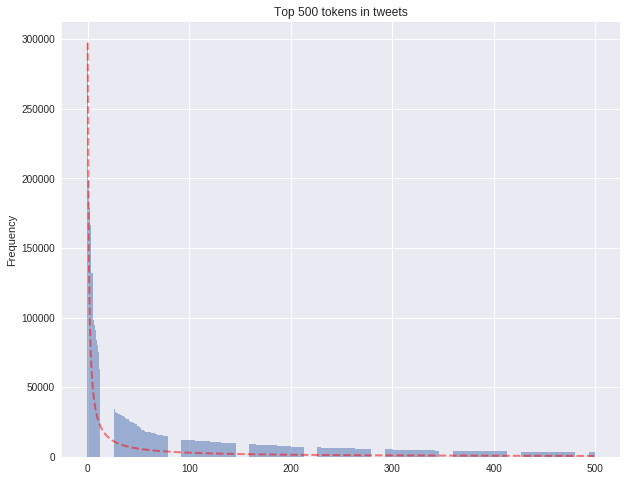

In [6]:
# Plotting tokens' frequency to see if they follow zipf's law( which states that the frequecy of the rth word => f(r) is directly prop with 1 / r)
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')

In [0]:
# Now we want to see what are the most frequent words in positive and negative tweets seperately.
stopwords_list = stopwords.words('arabic')

cvec = CountVectorizer(stop_words=stopwords_list,max_features=10000) # Removing stop words this time and limiting studied words to 10k
cvec.fit(df_clean.text)
document_matrix = cvec.transform(df_clean.text)

In [0]:
# Processing negative tweets
%%time
neg_batches = np.linspace(0,798491,10).astype(int)
i=0
neg_tf = []
while i < len(neg_batches)-1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    print (neg_batches[i+1],"entries' term freuquency calculated")
    i += 1

In [0]:
# Processing positive tweets
%%time
pos_batches = np.linspace(800000,1599999,10).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    print (pos_batches[i+1],"entries' term freuquency calculated")
    i += 1

In [10]:
# Displaying the top frequent words(non-stop) in both positive and negative tweets
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
الله,208140,53648,261788
اللي,40665,65146,105811
انا,47071,54189,101260
قال,84482,5290,89772
والله,42426,31845,74271
يوم,43431,20526,63957
ان,26517,32794,59311
ال,39448,5186,44634
كان,21897,20704,42601
مش,16897,23318,40215


Text(0.5,1,u'Negative Frequency vs Positive Frequency')

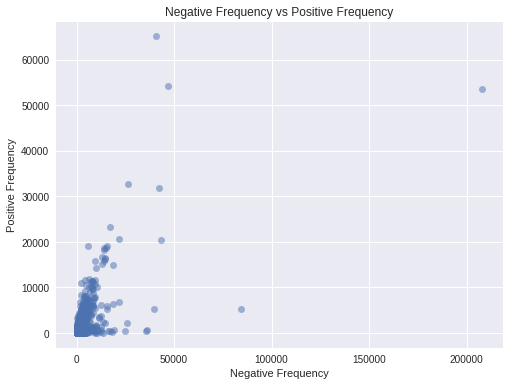

In [11]:
# We noticed in the above many neutral words occuring in both classes, let's plot the negative frequency of a word on X-axis, and the positive frequency on Y-axis
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

In [18]:
# As we can't infer much meaning from the previous plots, let's define a pos_rate and neg_rate, to indicate the rate of freq of a word in a certain class vs the other class
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

,negative,positive,total,pos_rate
القسا,0,265,265,1.0
ماصفا,0,425,425,1.0
صابتك,0,197,197,1.0
أهدم,0,176,176,1.0
وتبك,0,187,187,1.0
طاوع,0,221,221,1.0
هندسى,0,223,223,1.0
tech,0,410,410,1.0
بوجهينك,0,288,288,1.0
ياهييه,0,235,235,1.0


In [19]:
# Now let's define a freq_pct representing the rate by which a word occurs in a certain class only
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct
اللي,40665,65146,105811,0.615683,0.013541
انا,47071,54189,101260,0.535147,0.011263
الله,208140,53648,261788,0.204929,0.011151
ان,26517,32794,59311,0.552916,0.006816
والله,42426,31845,74271,0.428768,0.006619
مش,16897,23318,40215,0.579833,0.004847
كان,21897,20704,42601,0.485998,0.004303
يوم,43431,20526,63957,0.320934,0.004266
بـ,5836,19170,25006,0.766616,0.003985
شي,15724,19084,34808,0.548265,0.003967


In [20]:
term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']]) if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), axis=1)               
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean
اللي,40665,65146,105811,0.615683,0.013541,0.026499
انا,47071,54189,101260,0.535147,0.011263,0.022062
الله,208140,53648,261788,0.204929,0.011151,0.021151
ان,26517,32794,59311,0.552916,0.006816,0.013467
والله,42426,31845,74271,0.428768,0.006619,0.013037
مش,16897,23318,40215,0.579833,0.004847,0.009613
كان,21897,20704,42601,0.485998,0.004303,0.008531
يوم,43431,20526,63957,0.320934,0.004266,0.008421
بـ,5836,19170,25006,0.766616,0.003985,0.007928
شي,15724,19084,34808,0.548265,0.003967,0.007876


In [21]:
from scipy.stats import norm

def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])

term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])

term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])

term_freq_df2.sort_values(by='pos_normcdf_hmean',ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean
بله,598,3802,4400,0.864091,0.000790,0.001579,0.941449,0.983933,0.962222
مبارك,391,3192,3583,0.890874,0.000663,0.001326,0.954668,0.959867,0.957261
d8,2346,10912,13258,0.823050,0.002268,0.004524,0.915547,1.000000,0.955912
d9,2048,8437,10485,0.804673,0.001754,0.003500,0.901485,1.000000,0.948190
مرحبا,725,3293,4018,0.819562,0.000684,0.001368,0.913001,0.965186,0.938368
ماني,1893,6841,8734,0.783261,0.001422,0.002839,0.883024,0.999980,0.937870
والا,1221,4440,5661,0.784314,0.000923,0.001844,0.883985,0.994681,0.936072
بـ,5836,19170,25006,0.766616,0.003985,0.007928,0.867069,1.000000,0.928802
ماهو,1922,5987,7909,0.756986,0.001244,0.002485,0.857183,0.999809,0.923019
غيري,1295,3938,5233,0.752532,0.000819,0.001635,0.852447,0.987143,0.914864


In [22]:
term_freq_df2['neg_rate'] = term_freq_df2['negative'] * 1./term_freq_df2['total']

term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] * 1./term_freq_df2['negative'].sum()

term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])                                                                if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0                                                                else 0), axis=1)
                                                       
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])

term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])

term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])

term_freq_df2.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
رواه,13662,86,13748,0.006255,0.000018,0.000036,0.007508,0.399385,0.014738,0.993745,0.002591,0.005169,0.992492,0.999999,0.996231
قدير,10405,102,10507,0.009708,0.000021,0.000042,0.007848,0.403377,0.015396,0.990292,0.001974,0.003939,0.992152,0.999804,0.995963
صلى,35515,462,35977,0.012842,0.000096,0.000191,0.008168,0.495080,0.016072,0.987158,0.006736,0.013382,0.991832,1.000000,0.995899
رسول,24661,377,25038,0.015057,0.000078,0.000156,0.008402,0.473220,0.016510,0.984943,0.004678,0.009311,0.991598,1.000000,0.995781
قبلي,9370,88,9458,0.009304,0.000018,0.000037,0.007807,0.399883,0.015316,0.990696,0.001777,0.003548,0.992193,0.999248,0.995708
عرفة,18304,313,18617,0.016813,0.000065,0.000130,0.008591,0.456811,0.016865,0.983187,0.003472,0.006919,0.991409,1.000000,0.995686
وسلم,36307,649,36956,0.017561,0.000135,0.000268,0.008673,0.543131,0.017073,0.982439,0.006887,0.013677,0.991327,1.000000,0.995645
رضي,16345,343,16688,0.020554,0.000071,0.000142,0.009006,0.464495,0.017670,0.979446,0.003100,0.006181,0.990994,1.000000,0.995476
دعاء,12252,274,12526,0.021875,0.000057,0.000114,0.009157,0.446845,0.017947,0.978125,0.002324,0.004637,0.990843,0.999987,0.995394
شريك,9402,212,9614,0.022051,0.000044,0.000088,0.009178,0.431074,0.017973,0.977949,0.001783,0.003560,0.990822,0.999277,0.995032


Text(0.5,1,u'neg_hmean vs pos_hmean')

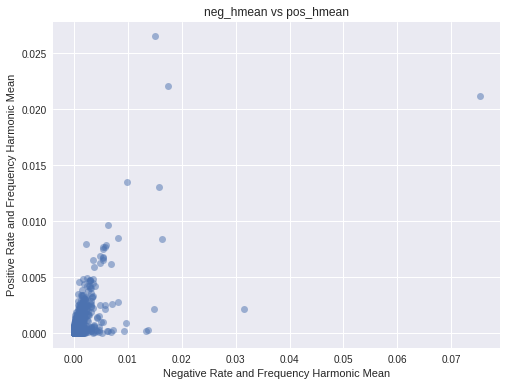

In [23]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

Text(0.5,1,u'neg_normcdf_hmean vs pos_normcdf_hmean')

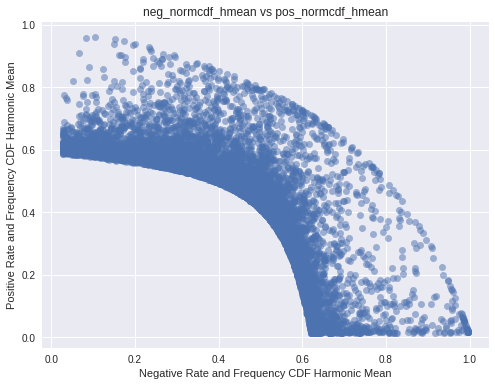

In [24]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

In [25]:
output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df2.pos_normcdf_hmean), high=max(term_freq_df2.pos_normcdf_hmean))

p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')

p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df2,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})

hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

Loading BokehJS ...

In [0]:
import nltk
nltk.download("stopwords")
stopwords_list = set(stopwords.words('arabic'))
print(stopwords_list)

In [0]:
# Training starts from here
x = df_clean.text
y = df_clean.target

SEED = 2000

#split clean data to two sets : training , validation and test
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
#split the second set into two other sets : validation , test 
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)


print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),(len(x_train[y_train == 0]) / (len(x_train)*1.))*100,(len(x_train[y_train == 4]) / (len(x_train)*1.))*100))

print ("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),(len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,(len(x_validation[y_validation == 4]) / (len(x_validation)*1.))*100))

print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),(len(x_test[y_test == 0]) / (len(x_test)*1.))*100,(len(x_test[y_test == 4]) / (len(x_test)*1.))*100))




In [18]:
# Using Text Blob Python libary for sentiment analysis as baseline for accuracy

tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
target_names = ['Positive', 'Negative']
tbpred = [0 if n < 0 else 4 for n in tbresult]
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[4,0]))
confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive','predicted_negative'])

print ("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100))
print ("-"*80)
print ("Confusion Matrix\n")
print (confusion)
print ("-"*80)
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. 
# The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. 
# The recall is intuitively the ability of the classifier to find all the positive samples.

# The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, 
# where an F-beta score reaches its best value at 1 and worst score at 0.
print ("Classification Report\n")
print (classification_report(y_validation, tbpred,target_names=target_names))

ValueError: ignored